In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import tensorflow as tf
import time
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
import seaborn as sns

%matplotlib inline

In [2]:
def plot_graphs(history):
    fig = go.Figure()

    fig = make_subplots(rows=1, cols=2)

    fig.append_trace(
        go.Scatter(
            y=history.history['accuracy'],
            name='Train Accuracy',
            mode='lines+markers'
        ),
        row=1, col=1
    )

    fig.append_trace(
        go.Scatter(
            y=history.history['val_accuracy'],
            name='Validation Accuracy',
            mode='lines+markers'
        ),
        row=1, col=1
    )

    fig.append_trace(
        go.Scatter(
            y=history.history['loss'],
            name='Train Loss',
            mode='lines+markers'
        ),
        row=1, col=2
    )

    fig.append_trace(
        go.Scatter(
            y=history.history['val_loss'],
            name='Validation Loss',
            mode='lines+markers'
        ),
        row=1, col=2
    )

    fig.update_layout(height=500, width=1000, title_text="Accuracy and Loss", template="plotly_dark")
    fig.show()

In [3]:
def plot_cm(model, test_ds): 
    y_pred = model.predict(test_ds)
    y_pred = np.round(y_pred)

    y_true = []
    for images, labels in test_ds:
        y_true.append(labels.numpy())
        
    y_true = np.concatenate(y_true)
    y_true = y_true.astype(int)

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 10))
    sns.set(font_scale=2.0)
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=False, cmap='Blues')
    plt.xticks(ticks=[0.5, 1.5], labels=['Real', 'Fake'])
    plt.yticks(ticks=[0.5, 1.5], labels=['Real', 'Fake'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

In [4]:
# Check if GPU is available
devices = tf.config.list_physical_devices('GPU')
print(len(devices)) 

1


In [5]:
# !unzip 140k-faces.zip

In [6]:
# !mv real_vs_fake/real-vs-fake/ ./real-vs-fake
# !rm -rf real_vs_fake

In [7]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

batch_size = 32
width = 128
height = 128

data_dir = 'real-vs-fake/'

Text(0.5, 1.0, 'Real')

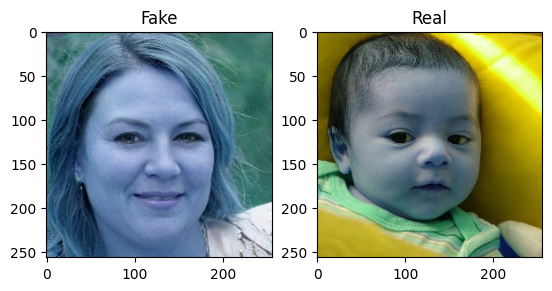

In [8]:
fig, axs = plt.subplots(1, 2)
fake = cv2.imread(data_dir + 'train/fake/0A0IAK9X2W.jpg')
real = cv2.imread(data_dir + 'train/real/00000.jpg')
axs[0].imshow(fake)
axs[0].set_title('Fake')
axs[1].imshow(real)
axs[1].set_title('Real')

In [9]:
train_ds = image_dataset_from_directory(
    data_dir+"/train",
    validation_split = 0.2,
    subset = 'training',
    seed = 200,
    image_size = (width, height),
    batch_size = batch_size,
    label_mode = 'binary'
)

val_ds = image_dataset_from_directory(
    data_dir+"/test",
    validation_split = 0.2,
    subset = 'validation',
    seed = 200,
    image_size = (width, height),
    batch_size = batch_size,
    label_mode = 'binary'
)

Found 100000 files belonging to 2 classes.
Using 80000 files for training.
Found 20000 files belonging to 2 classes.
Using 4000 files for validation.


# Base Model

In [31]:
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# Input Layer
x_input = Input((width, height, 3))

# Layer 1
x = Conv2D(32, (3, 3), padding='same')(x_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Layer 2
x = MaxPooling2D((2, 2))(x)

# Layer 3
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Layer 4
x = MaxPooling2D((2, 2))(x)

# Layer 5
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Layer 6
x = MaxPooling2D((2, 2))(x)

# Layer 7
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Layer 8
x = MaxPooling2D((2, 2))(x)

# Layer 9
x = Flatten()(x)

# Layer 10
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.4)(x)

# Layer 11
x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.4)(x)

# Layer 12
x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)

# Ouput Layer
x = Dense(1)(x)
x = Activation('sigmoid')(x)

# Create Model
model = Model(inputs=x_input, outputs=x)

In [32]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_14 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
activation_16 (Activation)   (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_15 (Batc (None, 64, 64, 64)        256 

In [33]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback

class CustomEarlyStopping(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.98):
            print("\nReached 98% accuracy. Stopping training!")
            self.model.stop_training = True

callbacks = [
    # CustomEarlyStopping(),
    # EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1, min_lr=0.000001, verbose=1)
]


In [34]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = 'checkpoints/'

checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_weights_only = True,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True
)

In [36]:
start = time.time()
print("Training started at: ", time.ctime(start))

history = model.fit(
    train_ds,
    epochs=10,  
    validation_data=val_ds,
    callbacks=[callbacks, checkpoint_callback],
)   

Training started at:  Mon Jun  5 09:55:46 2023
Epoch 1/10
2500/2500 [==============================] - 64s 25ms/step - loss: 0.3847 - accuracy: 0.8208 - recall_2: 0.8314 - precision_2: 0.8143 - val_loss: 0.2604 - val_accuracy: 0.8870 - val_recall_2: 0.9759 - val_precision_2: 0.8279
Epoch 2/10
2500/2500 [==============================] - 56s 22ms/step - loss: 0.1574 - accuracy: 0.9377 - recall_2: 0.9412 - precision_2: 0.9347 - val_loss: 0.2346 - val_accuracy: 0.8953 - val_recall_2: 0.9794 - val_precision_2: 0.8377
Epoch 3/10
2500/2500 [==============================] - 59s 24ms/step - loss: 0.0940 - accuracy: 0.9644 - recall_2: 0.9666 - precision_2: 0.9624 - val_loss: 0.0907 - val_accuracy: 0.9660 - val_recall_2: 0.9558 - val_precision_2: 0.9754
Epoch 4/10
2500/2500 [==============================] - 70s 28ms/step - loss: 0.0586 - accuracy: 0.9783 - recall_2: 0.9799 - precision_2: 0.9768 - val_loss: 0.1316 - val_accuracy: 0.9455 - val_recall_2: 0.9011 - val_precision_2: 0.9884
Epoch 5/1

In [42]:
end = time.time()
print("Training ended at: ", time.ctime(end))

# calculate the total training time
total_time = end - start
print("Total time taken to train the model: ", total_time)

Training ended at:  Mon Jun  5 10:06:51 2023
Total time taken to train the model:  664.6477806568146


In [43]:
plot_graphs(history)

In [44]:
# save model
model.save('base-model.h5')

In [45]:
# Load test data
test_ds = image_dataset_from_directory(
    data_dir+"/test",
    shuffle = False,
    image_size = (width, height),
    batch_size = batch_size,
    label_mode = 'binary',
)

# Evaluate model
results = model.evaluate(test_ds)

Found 20000 files belonging to 2 classes.
625/625 [==============================] - 8s 13ms/step - loss: 0.0343 - accuracy: 0.9897 - recall_2: 0.9908 - precision_2: 0.9886


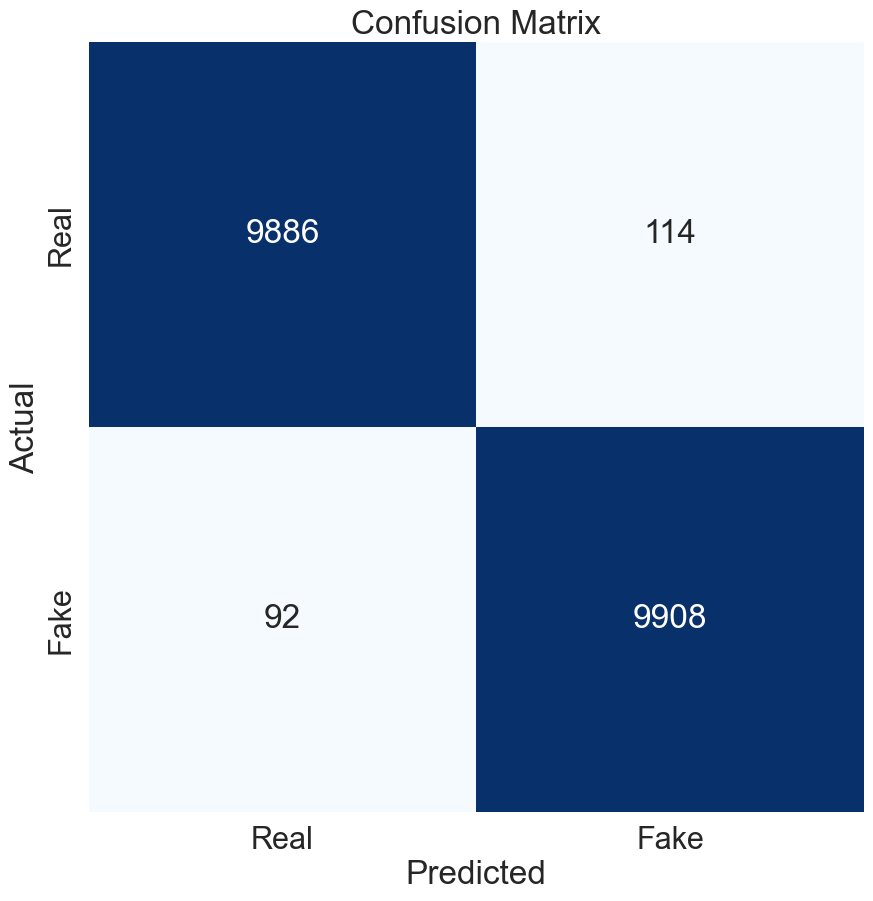

In [46]:
plot_cm(model, test_ds)

# ResNet50

In [47]:
# load vgg 16
from tensorflow.keras.applications.resnet import ResNet50

resnet = ResNet50(
    include_top = False,
    weights = 'imagenet',
    input_shape = (width, height, 3)
)

resnet.summary()


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [48]:
# Freeze layers

for layer in resnet.layers:
    layer.trainable = False

In [49]:
from tensorflow.keras.regularizers import l2

x = Flatten()(resnet.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs = resnet.input, outputs = x)

In [50]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [51]:
model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [52]:
start = time.time()
print("Training started at: ", time.ctime(start))

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[callbacks, checkpoint_callback],
)

Training started at:  Mon Jun  5 10:09:07 2023
Epoch 1/10
2500/2500 [==============================] - 69s 26ms/step - loss: 0.4674 - accuracy: 0.7828 - val_loss: 0.3661 - val_accuracy: 0.8403
Epoch 2/10
2500/2500 [==============================] - 62s 25ms/step - loss: 0.3529 - accuracy: 0.8466 - val_loss: 0.3523 - val_accuracy: 0.8345
Epoch 3/10
2500/2500 [==============================] - 60s 24ms/step - loss: 0.3113 - accuracy: 0.8690 - val_loss: 0.3063 - val_accuracy: 0.8727
Epoch 4/10
2500/2500 [==============================] - 59s 23ms/step - loss: 0.2799 - accuracy: 0.8831 - val_loss: 0.2983 - val_accuracy: 0.8740
Epoch 5/10
2500/2500 [==============================] - 61s 25ms/step - loss: 0.2528 - accuracy: 0.8951 - val_loss: 0.2982 - val_accuracy: 0.8820
Epoch 6/10
2500/2500 [==============================] - 59s 23ms/step - loss: 0.2343 - accuracy: 0.9046 - val_loss: 0.2926 - val_accuracy: 0.8808
Epoch 7/10
2500/2500 [==============================] - 55s 22ms/step - loss:

In [53]:
end = time.time()
print("Training ended at: ", time.ctime(end))

# calculate the total training time
total_time = end - start
print("Total time taken to train the model: ", total_time)

Training ended at:  Mon Jun  5 10:18:59 2023
Total time taken to train the model:  592.1423897743225


In [54]:
plot_graphs(history)


In [55]:
# Load test data
test_ds = image_dataset_from_directory(
    data_dir+"/test",
    shuffle = False,
    image_size = (width, height),
    batch_size = batch_size,
    label_mode = 'binary',
)

# Evaluate model
results = model.evaluate(test_ds)

Found 20000 files belonging to 2 classes.
625/625 [==============================] - 11s 18ms/step - loss: 0.2791 - accuracy: 0.8961


In [56]:
model.save('resnet50-model.h5')

c:\Users\reyna\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



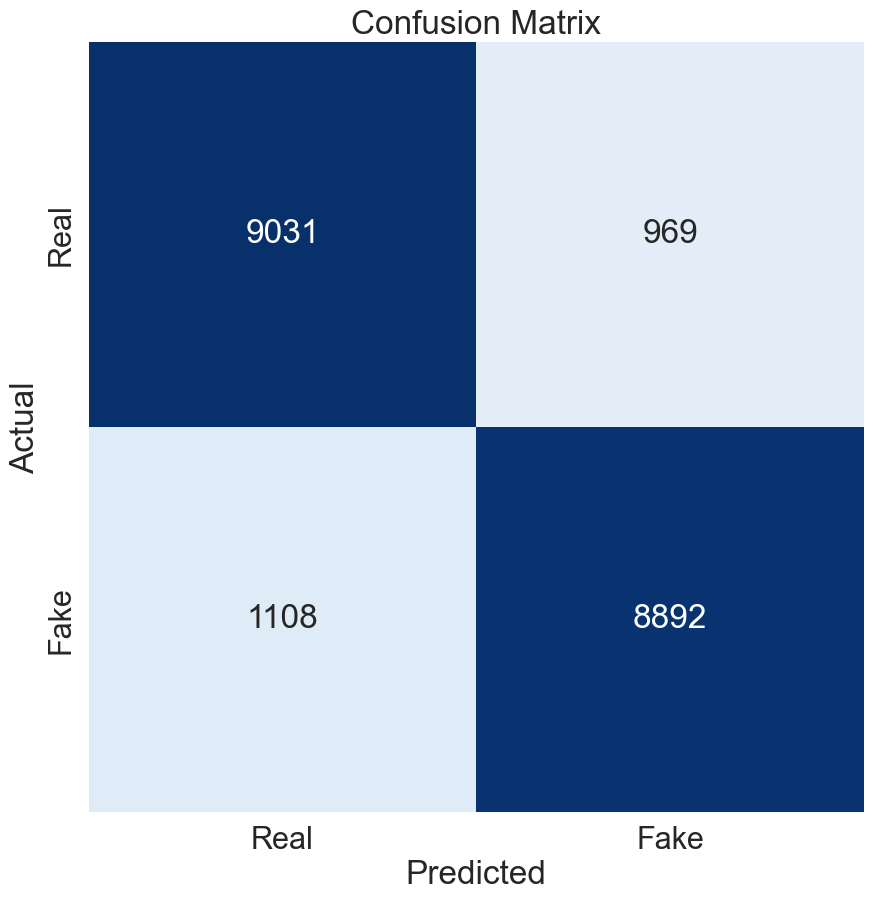

In [57]:
plot_cm(model, test_ds)

# Efficient Net

In [58]:
# import efficientnet
from tensorflow.keras.applications import EfficientNetB4

efficientnet = EfficientNetB4(
    include_top = False,
    weights = 'imagenet',
    input_shape = (width, height, 3)
)   

efficientnet.summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 128, 128, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 128, 128, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 129, 129, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [59]:
# Freeze layers

for layer in efficientnet.layers:
    layer.trainable = False

In [60]:
from tensorflow.keras.regularizers import l2

x = Flatten()(resnet.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs = resnet.input, outputs = x)

In [61]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [62]:
model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [63]:
start = time.time()
print("Training started at: ", time.ctime(start))

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[callbacks, checkpoint_callback],
)

Training started at:  Mon Jun  5 10:19:29 2023
Epoch 1/10
2500/2500 [==============================] - 59s 22ms/step - loss: 0.4741 - accuracy: 0.7783 - val_loss: 0.3516 - val_accuracy: 0.8518
Epoch 2/10
2500/2500 [==============================] - 54s 22ms/step - loss: 0.3523 - accuracy: 0.8463 - val_loss: 0.3216 - val_accuracy: 0.8620
Epoch 3/10
2500/2500 [==============================] - 58s 23ms/step - loss: 0.3085 - accuracy: 0.8698 - val_loss: 0.3050 - val_accuracy: 0.8715
Epoch 4/10
2500/2500 [==============================] - 58s 23ms/step - loss: 0.2761 - accuracy: 0.8842 - val_loss: 0.3019 - val_accuracy: 0.8705
Epoch 5/10
2500/2500 [==============================] - 57s 23ms/step - loss: 0.2534 - accuracy: 0.8953 - val_loss: 0.2978 - val_accuracy: 0.8770
Epoch 6/10
2500/2500 [==============================] - 56s 22ms/step - loss: 0.2363 - accuracy: 0.9033 - val_loss: 0.2979 - val_accuracy: 0.8800
Epoch 7/10
2500/2500 [==============================] - 62s 25ms/step - loss:

In [64]:
end = time.time()
print("Training ended at: ", time.ctime(end))

# calculate the total training time
total_time = end - start
print("Total time taken to train the model: ", total_time)

Training ended at:  Mon Jun  5 10:29:14 2023
Total time taken to train the model:  584.8455348014832


In [65]:
plot_graphs(history)

In [66]:
# Load test data
test_ds = image_dataset_from_directory(
    data_dir+"/test",
    shuffle = False,
    image_size = (width, height),
    batch_size = batch_size,
    label_mode = 'binary',
)

# Evaluate model
results = model.evaluate(test_ds)

Found 20000 files belonging to 2 classes.
625/625 [==============================] - 13s 21ms/step - loss: 0.2933 - accuracy: 0.8899


In [67]:
model.save('efficientnetb4-model.h5')

c:\Users\reyna\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



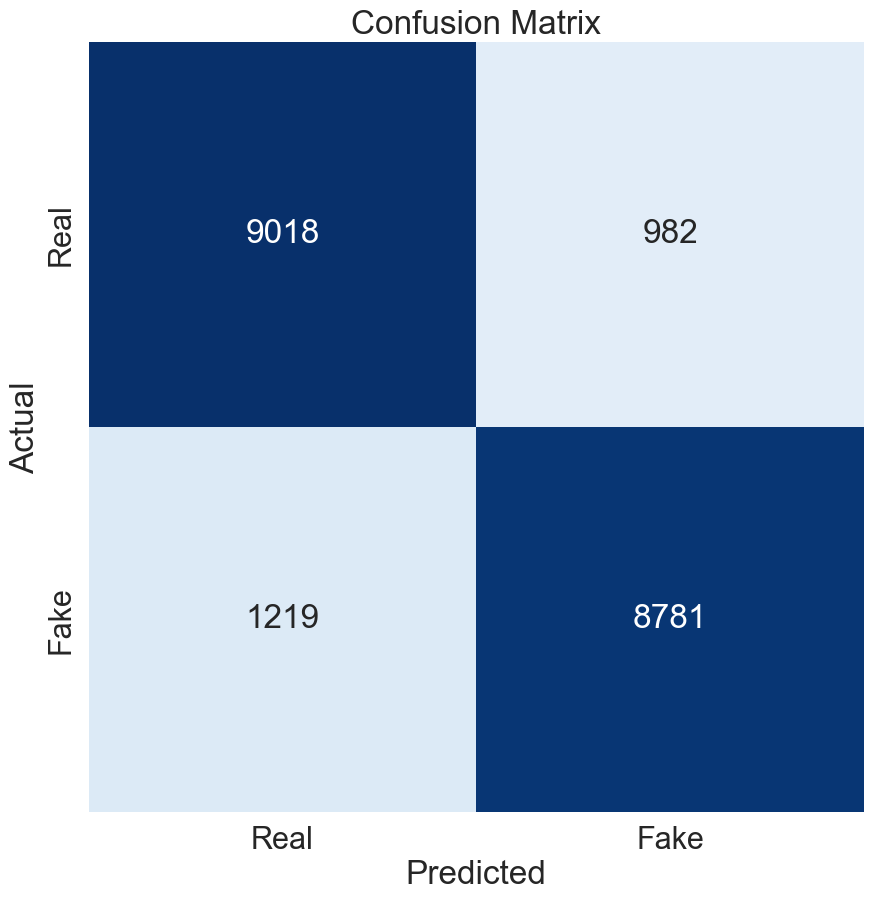

In [68]:
plot_cm(model, test_ds)

# Accuracy Comparison

In [70]:
# plot accuracy comparison for three models Base Model (97.58%), VGG-16(88.89%), Efficient-Net B4(89.51%) using plotly
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Bar(
    x=['Base Model (98.97%)', 'ResNet50 (89.61%)', 'Efficient-Net B4 (88.99%)'],
    y=[97.58, 88.89, 89.51],
    name='Accuracy',
    marker_color='indianred'
))

fig.update_layout(
    title='Accuracy Comparison',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Accuracy',
        titlefont_size=16,
        tickfont_size=14,
    ),

    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),

    barmode='group',
    bargap=0.15,
    bargroupgap=0.1,
    template='plotly_dark'
)

fig.show()
